# MULTILABEL CLASSIFICATION

A multilabel setting is identified by samples that can simultaneously belong to more than one class. For example,  

In [ ]:
# Download the dataset
!kaggle datasets list

In [ ]:
!kaggle datasets download -d shivanandmn/multilabel-classification-dataset

In [ ]:
!tar -xf multilabel-classification-dataset.zip

In [ ]:
# Let's start to explore the dataset
import pandas as pd
df = pd.read_csv('train.csv')
df.head()

print(df.iloc[2])

In [ ]:
# First of all, we have to create the dataset
from dataset import MultiLabelDataset
from torch.utils.data import random_split

dataset = MultiLabelDataset(data_path="train.csv", split='train')
# Split the two in train and validation
train_dataset, test_dataset = random_split(dataset, [int(len(dataset)*0.9), len(dataset) - int(len(dataset)*0.9)])
train_dataset, val_dataset = random_split(train_dataset, [int(len(train_dataset)*0.9), len(train_dataset) - int(len(train_dataset)*0.9)])

In [ ]:
import json
word_2_idx = json.load(open('w2i.json'))
# Define some quantities
output_dim = dataset.__getnlabels__()
pad_idx = 0
vocab_size = len(word_2_idx)+1

In [ ]:
# Try with the easiest model 

from model import EmbeddingMatrixModel
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.nn import BCEWithLogitsLoss
from tqdm import tqdm
from utils import convert_texts_to_indices

# HYPERPARAMETERS
EMBEDDING_DIM = 100
EPOCHS = 20
BATCH_SIZE = 32
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
LEARNING_RATE = 1e-3

# Model 
model = EmbeddingMatrixModel(embedding_dim=EMBEDDING_DIM, output_dim=output_dim, pad_idx=pad_idx, vocab_size=vocab_size)
# Send the model to the GPU 
model.to(DEVICE)

# Create the dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

# Create the optimizer
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)

# Create the loss function
criterion = BCEWithLogitsLoss()

# Send the model to the GPU
model.train()

train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    train_loss = 0
    for batch in tqdm(train_loader):
        titles, abst, labels = batch
        labels = labels.to(DEVICE)
        # Prepare the titles
        titles_batch = convert_texts_to_indices(texts=titles,word2idx=word_2_idx,pad_idx=pad_idx)
        titles_batch = titles_batch.to(DEVICE)
        optimizer.zero_grad()
        out, loss_mask = model(titles_batch)
        out = out[loss_mask.squeeze()==1]
        labels = labels[loss_mask.squeeze()==1]
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # EVALUATE ON THE VALIDATION SPLIT 
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_loader):
            titles, abst, labels = batch
            labels = labels.to(DEVICE)
            # Prepare the titles
            titles_batch = convert_texts_to_indices(texts=titles,word2idx=word_2_idx,pad_idx=pad_idx)
            titles_batch = titles_batch.to(DEVICE)
            out, loss_mask = model(titles_batch)
            out = out[loss_mask.squeeze()==1]
            labels = labels[loss_mask.squeeze()==1]
            loss = criterion(out, labels)
            
            val_loss += loss.item()
        
    print("Training loss epoch {}: {}".format(epoch, round(train_loss/len(train_loader),4)))
    print("Validation loss epoch {}: {}".format(epoch, round(val_loss/len(val_loader),4)))
    train_losses.append(train_loss/len(train_loader))
    val_losses.append(val_loss/len(val_loader))
    

In [ ]:
# Plot val losses and train losses
import matplotlib.pyplot as plt

plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.show()

In [ ]:
# Calculate the test loss and accuracy 

BATCH_SIZE = 128
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

model.eval()
val_loss = 0
correct = 0
total = 0

test_predictions = []
test_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        titles, abst, labels = batch
        labels = labels.to(DEVICE)
        # Prepare the titles
        titles_batch = convert_texts_to_indices(texts=titles,word2idx=word_2_idx,pad_idx=pad_idx)
        titles_batch = titles_batch.to(DEVICE)
        out, loss_mask = model(titles_batch)
        loss = criterion(out, labels)
        val_loss += loss.item()
        # Convert the output with sigmoid 
        out = torch.sigmoid(out)
        out = torch.round(out)
        # Calculate the accuracy
        for i in range(out.size(0)):
            if torch.equal(out[i], labels[i]):
                correct += 1
        total += labels.size(0)

        test_predictions.extend(out.tolist())
        test_labels.extend(labels.tolist())

print("Validation loss: {}".format(round(val_loss/len(test_loader),4)))
print("Validation accuracy: {}".format(round(correct/total,4)))

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

test_labels = np.array(test_labels)
test_predictions = np.array(test_predictions)
report = classification_report(test_labels,test_predictions)
print(report)

In [ ]:
# Try with the easiest model 

from model import EmbeddingMatrixModel
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.nn import BCEWithLogitsLoss
from tqdm import tqdm
from utils import convert_texts_to_indices

# HYPERPARAMETERS
EMBEDDING_DIM = 100
EPOCHS = 20
BATCH_SIZE = 32
DEVICE = 'cuda:1' if torch.cuda.is_available() else 'cpu'
LEARNING_RATE = 1e-3

# Model 
model = EmbeddingMatrixModel(embedding_dim=EMBEDDING_DIM, output_dim=output_dim, pad_idx=pad_idx, vocab_size=vocab_size)
# Send the model to the GPU 
model.to(DEVICE)

# Create the dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

# Create the optimizer
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay=1e-3)

# Create the loss function
criterion = BCEWithLogitsLoss()

# Send the model to the GPU
model.train()

train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    train_loss = 0
    for batch in tqdm(train_loader):
        titles, abst, labels = batch
        labels = labels.to(DEVICE)
        # Prepare the titles
        titles_batch = convert_texts_to_indices(texts=titles,word2idx=word_2_idx,pad_idx=pad_idx)
        titles_batch = titles_batch.to(DEVICE)
        optimizer.zero_grad()
        out, loss_mask = model(titles_batch)
        out = out[loss_mask.squeeze()==1]
        labels = labels[loss_mask.squeeze()==1]
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # EVALUATE ON THE VALIDATION SPLIT 
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_loader):
            titles, abst, labels = batch
            labels = labels.to(DEVICE)
            # Prepare the titles
            titles_batch = convert_texts_to_indices(texts=titles,word2idx=word_2_idx,pad_idx=pad_idx)
            titles_batch = titles_batch.to(DEVICE)
            out, loss_mask = model(titles_batch)
            out = out[loss_mask.squeeze()==1]
            labels = labels[loss_mask.squeeze()==1]
            loss = criterion(out, labels)
            
            val_loss += loss.item()
        
    print("Training loss epoch {}: {}".format(epoch, round(train_loss/len(train_loader),4)))
    print("Validation loss epoch {}: {}".format(epoch, round(val_loss/len(val_loader),4)))
    train_losses.append(train_loss/len(train_loader))
    val_losses.append(val_loss/len(val_loader))
    

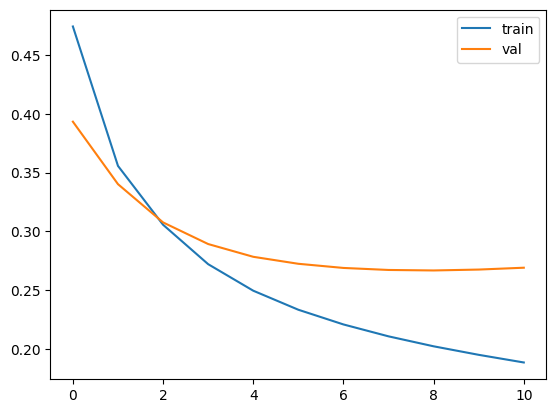

In [6]:
# Plot val losses and train losses
import matplotlib.pyplot as plt

plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.show()

In [7]:
# Calculate the test loss and accuracy 

BATCH_SIZE = 128
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

model.eval()
val_loss = 0
correct = 0
total = 0

test_predictions = []
test_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        titles, abst, labels = batch
        labels = labels.to(DEVICE)
        # Prepare the titles
        titles_batch = convert_texts_to_indices(texts=titles,word2idx=word_2_idx,pad_idx=pad_idx)
        titles_batch = titles_batch.to(DEVICE)
        out, loss_mask = model(titles_batch)
        loss = criterion(out, labels)
        val_loss += loss.item()
        # Convert the output with sigmoid 
        out = torch.sigmoid(out)
        out = torch.round(out)
        # Calculate the accuracy
        for i in range(out.size(0)):
            if torch.equal(out[i], labels[i]):
                correct += 1
        total += labels.size(0)

        test_predictions.extend(out.tolist())
        test_labels.extend(labels.tolist())

print("Validation loss: {}".format(round(val_loss/len(test_loader),4)))
print("Validation accuracy: {}".format(round(correct/total,4)))

100%|██████████| 17/17 [00:00<00:00, 17.31it/s]

Validation loss: 0.252
Validation accuracy: 0.5639


In [8]:
from sklearn.metrics import classification_report
import numpy as np

test_labels = np.array(test_labels)
test_predictions = np.array(test_predictions)
report = classification_report(test_labels,test_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.80      0.76      0.78       889
           1       0.84      0.76      0.80       579
           2       0.77      0.72      0.74       561
           3       0.72      0.64      0.68       535
           4       0.39      0.12      0.18        60
           5       0.29      0.10      0.14        21

   micro avg       0.78      0.71      0.74      2645
   macro avg       0.63      0.52      0.55      2645
weighted avg       0.77      0.71      0.74      2645
 samples avg       0.75      0.74      0.73      2645



c:\Users\Riccardo\miniconda3\envs\labs2024\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [9]:
# Do a step, use a RNN based model.
import json

word_2_idx = json.load(open('w2i.json'))
# HYPER PARAMETERS
embedding_dim = 100
hidden_dim = 256
output_dim = dataset.__getnlabels__()
pad_idx = 0
vocab_size = len(word_2_idx)+1

print(embedding_dim)
print(hidden_dim)
print(output_dim)
print(vocab_size)

100
256
6
4503


In [11]:
import torch
from model import SimpleRNNModel
# TRAIN LOOP 
# HYPERPARAMETERS
EPOCHS = 20
BATCH_SIZE = 32
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
LEARNING_RATE = 1e-3

# Model 
model = SimpleRNNModel(embedding_dim=embedding_dim, 
                       hidden_dim=hidden_dim, 
                       output_dim=output_dim, 
                       vocab_size=vocab_size, 
                       pad_idx=pad_idx)

# Send the model to the GPU 
model.to(DEVICE)

# Create the dataloaders
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

# Create the optimizer
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay=1e-3)

# Create the loss function
import torch.nn as nn
criterion = nn.BCEWithLogitsLoss()

from tqdm import tqdm
from utils import convert_texts_to_indices

# Send the model to the GPU
model.train()

train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    train_loss = 0
    for batch in tqdm(train_loader):
        titles, abst, labels = batch
        labels = labels.to(DEVICE)
        # Prepare the titles
        titles_batch = convert_texts_to_indices(texts=titles,word2idx=word_2_idx,pad_idx=pad_idx)
        titles_batch = titles_batch.to(DEVICE)
        optimizer.zero_grad()
        out = model(titles_batch)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # EVALUATE ON THE VALIDATION SPLIT 
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_loader):
            titles, abst, labels = batch
            labels = labels.to(DEVICE)
            # Prepare the titles
            titles_batch = convert_texts_to_indices(texts=titles,word2idx=word_2_idx,pad_idx=pad_idx)
            titles_batch = titles_batch.to(DEVICE)
            out = model(titles_batch)
            loss = criterion(out, labels)
            
            val_loss += loss.item()
    
    model.train()
        
    print("Training loss epoch {}: {}".format(epoch, round(train_loss/len(train_loader),4)))
    print("Validation loss epoch {}: {}".format(epoch, round(val_loss/len(val_loader),4)))
    train_losses.append(train_loss/len(train_loader))
    val_losses.append(val_loss/len(val_loader))

100%|██████████| 59/59 [00:00<00:00, 99.44it/s] 


Training loss epoch 0: 0.4242
Validation loss epoch 0: 0.403


100%|██████████| 59/59 [00:00<00:00, 101.14it/s]


Training loss epoch 1: 0.3981
Validation loss epoch 1: 0.3921


100%|██████████| 59/59 [00:00<00:00, 104.98it/s]


Training loss epoch 2: 0.3816
Validation loss epoch 2: 0.3754


100%|██████████| 59/59 [00:00<00:00, 99.00it/s] 


Training loss epoch 3: 0.3582
Validation loss epoch 3: 0.346


100%|██████████| 59/59 [00:00<00:00, 97.58it/s] 


Training loss epoch 4: 0.3321
Validation loss epoch 4: 0.3368


100%|██████████| 59/59 [00:00<00:00, 99.57it/s] 


Training loss epoch 5: 0.314
Validation loss epoch 5: 0.3145


100%|██████████| 59/59 [00:00<00:00, 96.97it/s] 


Training loss epoch 6: 0.3029
Validation loss epoch 6: 0.3118


100%|██████████| 59/59 [00:01<00:00, 50.93it/s]


Training loss epoch 7: 0.2989
Validation loss epoch 7: 0.3057


100%|██████████| 59/59 [00:00<00:00, 106.32it/s]


Training loss epoch 8: 0.2933
Validation loss epoch 8: 0.3105


100%|██████████| 59/59 [00:00<00:00, 95.37it/s] 

Training loss epoch 9: 0.2908
Validation loss epoch 9: 0.3043


In [12]:
# Calculate the test loss and accuracy 

BATCH_SIZE = 128
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

model.eval()
val_loss = 0
correct = 0
total = 0

test_predictions = []
test_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        titles, abst, labels = batch
        labels = labels.to(DEVICE)
        # Prepare the titles
        titles_batch = convert_texts_to_indices(texts=titles,word2idx=word_2_idx,pad_idx=pad_idx)
        titles_batch = titles_batch.to(DEVICE)
        out = model(titles_batch)
        loss = criterion(out, labels)
        val_loss += loss.item()
        # Convert the output with sigmoid 
        out = torch.sigmoid(out)
        out = torch.round(out)
        # Calculate the accuracy
        for i in range(out.size(0)):
            if torch.equal(out[i], labels[i]):
                correct += 1
        total += labels.size(0)

        test_predictions.extend(out.tolist())
        test_labels.extend(labels.tolist())

print("Validation loss: {}".format(round(val_loss/len(test_loader),4)))
print("Validation accuracy: {}".format(round(correct/total,4)))

100%|██████████| 17/17 [00:01<00:00, 15.81it/s]

Validation loss: 0.2954
Validation accuracy: 0.4743


In [13]:
from sklearn.metrics import classification_report
import numpy as np

test_labels = np.array(test_labels)
test_predictions = np.array(test_predictions)
report = classification_report(test_labels,test_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.74      0.75      0.74       889
           1       0.83      0.67      0.74       579
           2       0.82      0.52      0.63       561
           3       0.67      0.42      0.52       535
           4       0.00      0.00      0.00        60
           5       0.00      0.00      0.00        21

   micro avg       0.76      0.59      0.67      2645
   macro avg       0.51      0.39      0.44      2645
weighted avg       0.74      0.59      0.65      2645
 samples avg       0.63      0.62      0.61      2645



c:\Users\Riccardo\miniconda3\envs\labs2024\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Riccardo\miniconda3\envs\labs2024\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [14]:
# Load the dataset
from dataset import BERT_dataset
import torch
import random
from torch.utils.data import random_split

# FIX THE SEED
random.seed(45)
torch.manual_seed(0)

dataset = BERT_dataset(data_path="train.csv", split='train')
# Split the two in train and validation
train_dataset, test_dataset = random_split(dataset, [int(len(dataset)*0.9), len(dataset) - int(len(dataset)*0.9)])
train_dataset, val_dataset = random_split(train_dataset, [int(len(train_dataset)*0.9), len(train_dataset) - int(len(train_dataset)*0.9)])

Data loaded successfully, total number of train samples: 20972


c:\Users\Riccardo\miniconda3\envs\labs2024\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [15]:
target_labels = dataset.labels
id2label = {i:label for i, label in enumerate(target_labels)}
label2id = {label:i for i, label in enumerate(target_labels)}

In [17]:
import torch
from tqdm import tqdm
from transformers import AutoModelForSequenceClassification
from dataset import custom_collate

# HYPERPARAMETERS
EPOCHS = 10
BATCH_SIZE = 32
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
LEARNING_RATE = 2e-5

# Model 
model = AutoModelForSequenceClassification.from_pretrained("distilbert/distilbert-base-uncased", 
                                                           problem_type="multi_label_classification", 
                                                           num_labels=len(target_labels),
                                                           id2label=id2label,
                                                           label2id=label2id)

# for name, param in model.named_parameters():
#     if "classifier" not in name:
#         param.requires_grad = False
        
print("Model parameters: {}".format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

# Send the model to the GPU 
model.to(DEVICE)

# Create the dataloaders
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=8, collate_fn=custom_collate)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=8, collate_fn=custom_collate)

# Create the optimizer
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)

# Create the loss function
import torch.nn as nn
criterion = nn.BCEWithLogitsLoss()

# Send the model to the GPU
model.train()

train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    train_loss = 0
    for batch in tqdm(train_loader):
        input_ids, attention_mask, labels = batch
        labels = labels.to(DEVICE)
        input_ids = input_ids.to(DEVICE)
        attention_mask = attention_mask.to(DEVICE)
        optimizer.zero_grad()
        out = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = out.loss
        loss.backward()
        optimizer.step()
        
        train_loss+=loss.item()
    
    # EVALUATE ON THE VALIDATION SPLIT 
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_loader):
            input_ids, attention_mask, labels = batch
            labels = labels.to(DEVICE)
            input_ids = input_ids.to(DEVICE)
            attention_mask = attention_mask.to(DEVICE)
            out = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = out.loss
            val_loss += loss.item()
    
    model.train()
        
    print("Training loss epoch {}: {}".format(epoch, round(train_loss/len(train_loader),4)))
    print("Validation loss epoch {}: {}".format(epoch, round(val_loss/len(val_loader),4)))
    train_losses.append(train_loss/len(train_loader))
    val_losses.append(val_loss/len(val_loader))

c:\Users\Riccardo\miniconda3\envs\labs2024\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model parameters: 66958086


  0%|          | 0/531 [00:08<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# Calculate the test loss and accuracy 

BATCH_SIZE = 128
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, collate_fn=custom_collate)

model.eval()
val_loss = 0
correct = 0
total = 0

test_predictions = []
test_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids, attention_mask, labels = batch
        labels = labels.to(DEVICE)
        input_ids = input_ids.to(DEVICE)
        attention_mask = attention_mask.to(DEVICE)
        out = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = out.loss
        val_loss += loss.item()
        # Convert the output with sigmoid 
        out = torch.sigmoid(out["logits"])
        out = torch.round(out)
        # Calculate the accuracy
        for i in range(out.size(0)):
            if torch.equal(out[i], labels[i]):
                correct += 1
        total += labels.size(0)

        test_predictions.extend(out.tolist())
        test_labels.extend(labels.tolist())

print("Validation loss: {}".format(round(val_loss/len(test_loader),4)))
print("Validation accuracy: {}".format(round(correct/total,4)))

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

test_labels = np.array(test_labels)
test_predictions = np.array(test_predictions)
report = classification_report(test_labels,test_predictions)
print(report)